# EXPLORATION 17 : segmentation map으로 도로 이미지 만들기

## 루브릭 평가기준

|기준|상세|
|:--:|:--:|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

## Data load

In [1]:
import numpy as np
import tensorflow as tf

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
import os
import cv2
import matplotlib.pyplot as plt

data_path = os.getenv("HOME")+"/aiffel/E17/conditional_generation/data/cityscapes/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


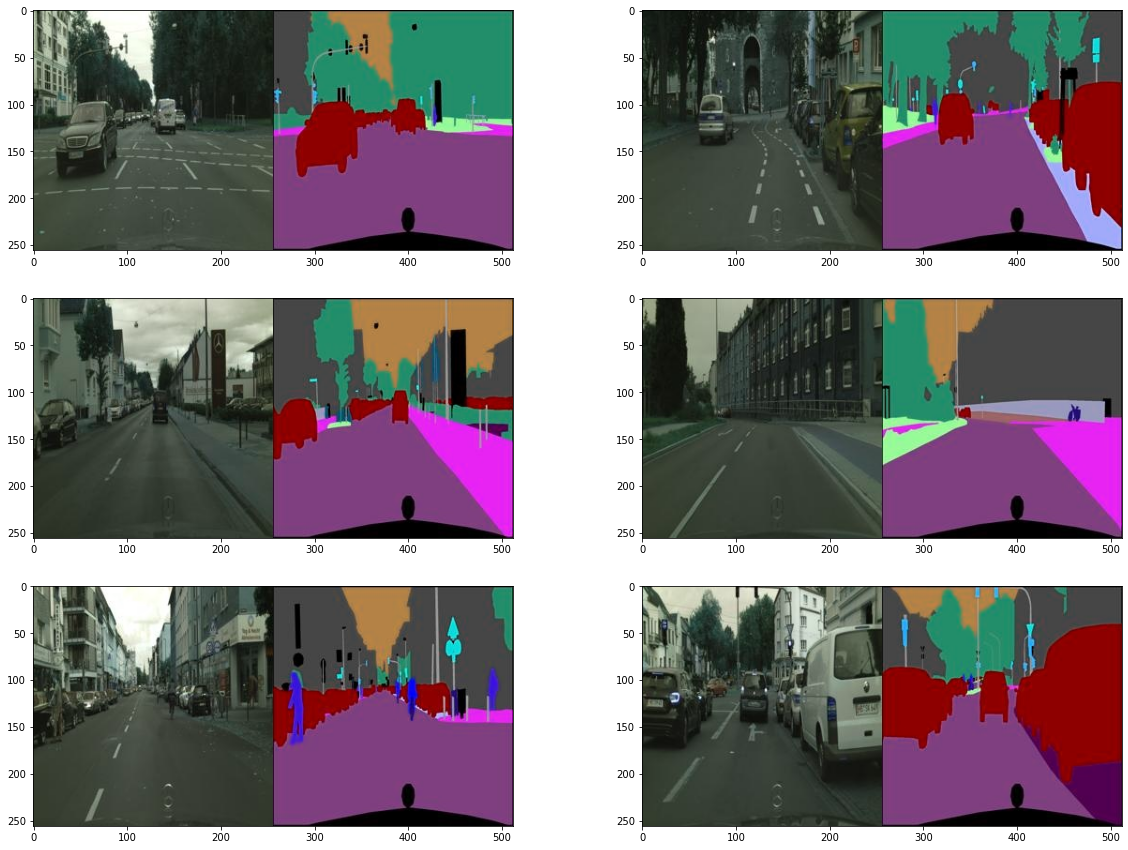

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


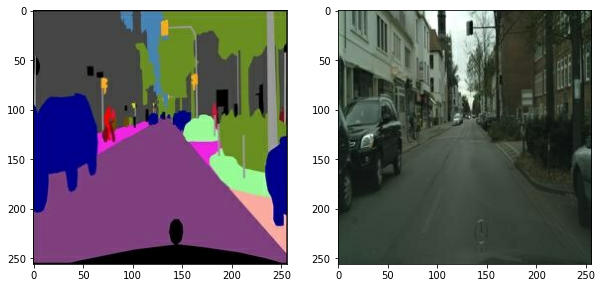

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real = img[:, :w, :] 
    real = tf.cast(real, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(real)

f = data_path + os.listdir(data_path)[1]
colored, real = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(colored))
plt.subplot(1,2,2); plt.imshow(denormalize(real))

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(colored, real):
    stacked = tf.concat([colored, real], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


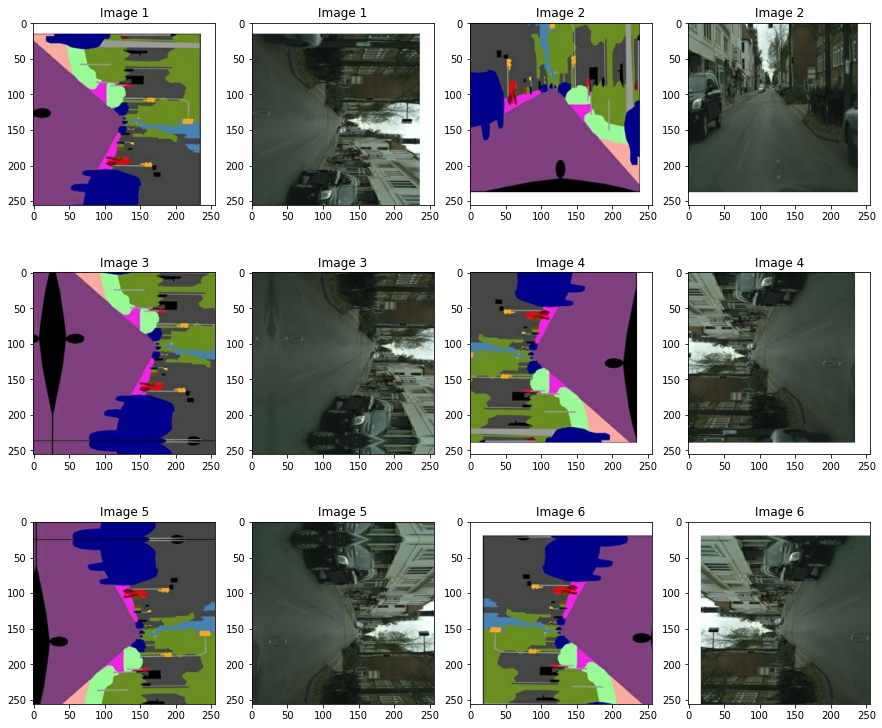

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_real, augmented_colored = apply_augmentation(colored, real)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

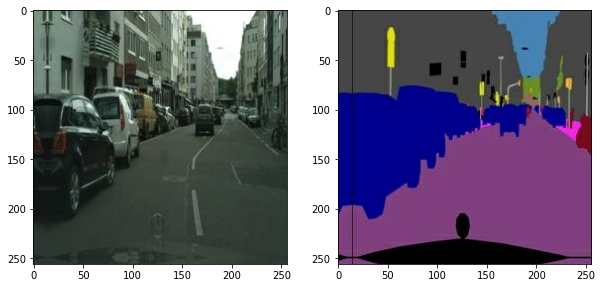

In [8]:
from tensorflow import data

def get_train(img_path):
    colored, real = load_img(img_path)
    colored, real = apply_augmentation(colored, real)
    return real, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
colored, real = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(colored[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real[0].astype(np.uint8))

## Generator 구성

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator 구성

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [13]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [15]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

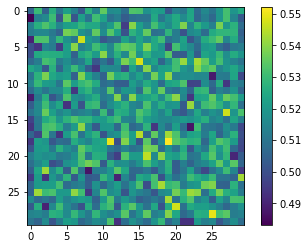

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 학습, 테스트

In [24]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [25]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [26]:
@tf.function
def train_step(colored, real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(colored, training=True)
        # Discriminator 예측
        fake_disc = discriminator(colored, fake_colored, training=True)
        real_disc = discriminator(colored, real, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [27]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (colored, real) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(colored, real)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9413                     
L1_loss:0.3720                     
Discriminator_loss:1.1476

EPOCH[1] - STEP[20]                     
Generator_loss:1.0497                     
L1_loss:0.2838                     
Discriminator_loss:1.2379

EPOCH[1] - STEP[30]                     
Generator_loss:1.4157                     
L1_loss:0.2456                     
Discriminator_loss:0.8348

EPOCH[1] - STEP[40]                     
Generator_loss:1.3720                     
L1_loss:0.2635                     
Discriminator_loss:0.8330

EPOCH[1] - STEP[50]                     
Generator_loss:1.3525                     
L1_loss:0.2707                     
Discriminator_loss:0.7878

EPOCH[1] - STEP[60]                     
Generator_loss:1.4258                     
L1_loss:0.2615                     
Discriminator_loss:0.6401

EPOCH[1] - STEP[70]                     
Generator_loss:1.7908                     
L1_loss:0.2810                    

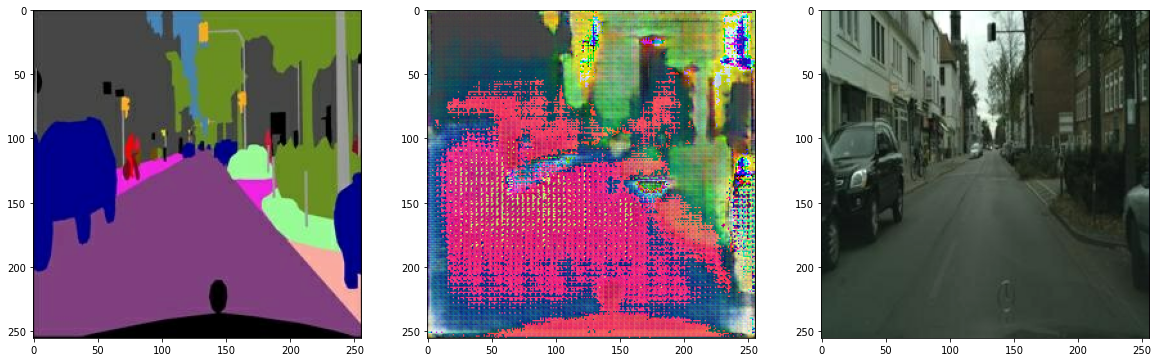

In [28]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
colored, real = load_img(f)

pred = generator(tf.expand_dims(colored, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(real))

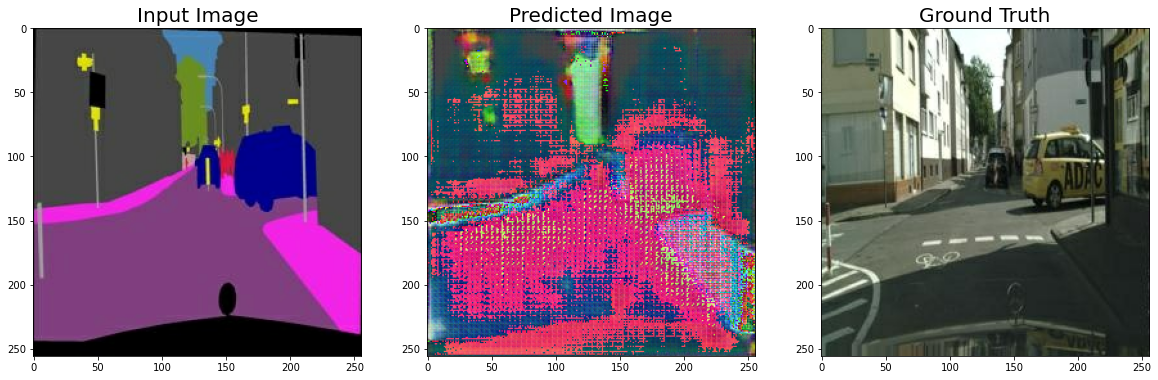

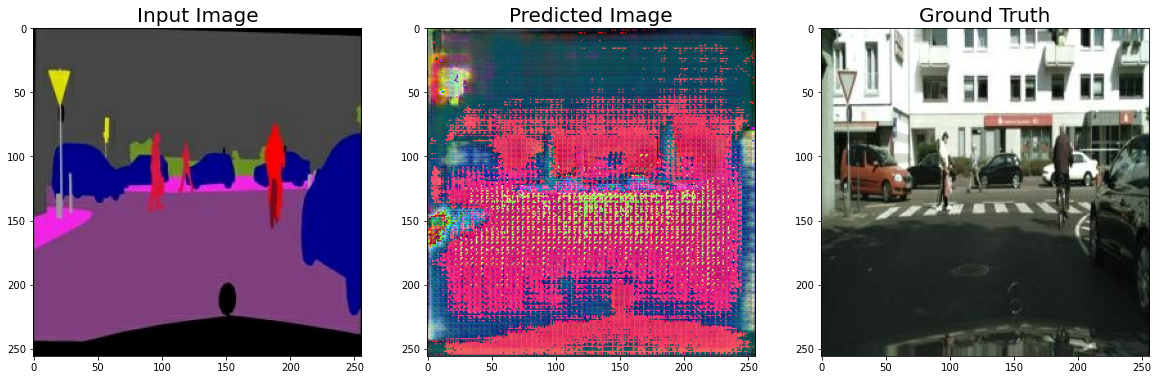

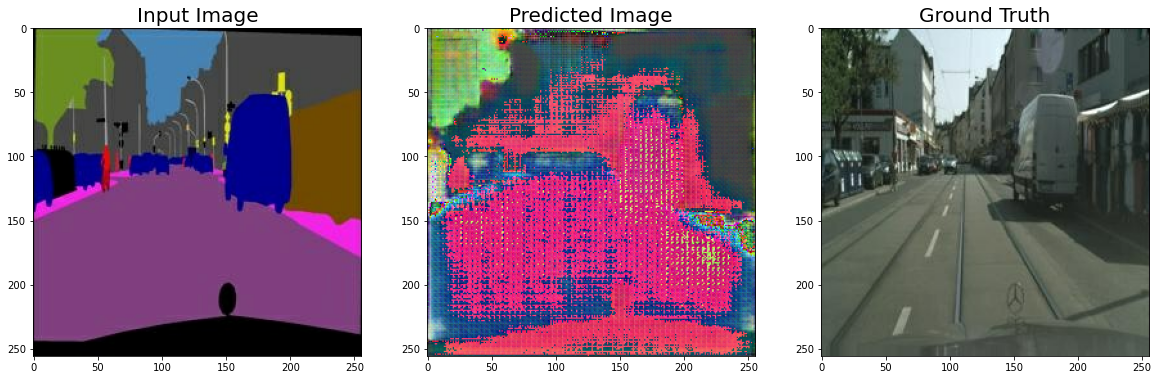

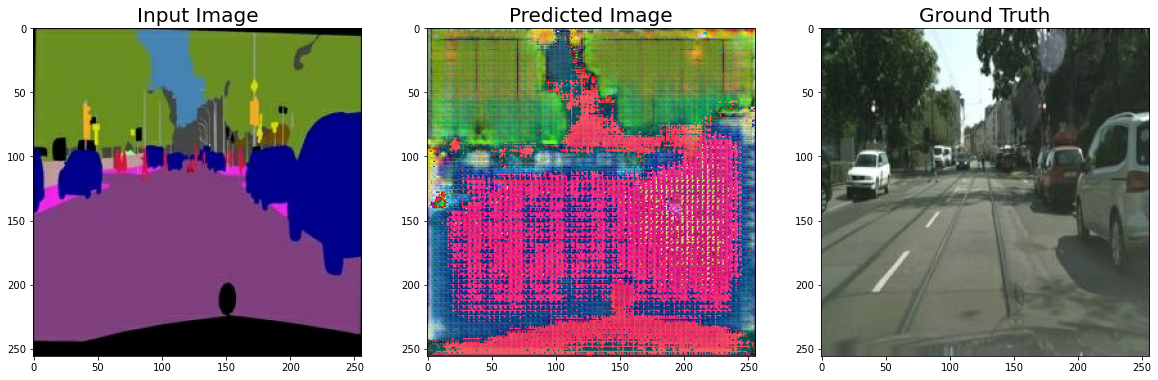

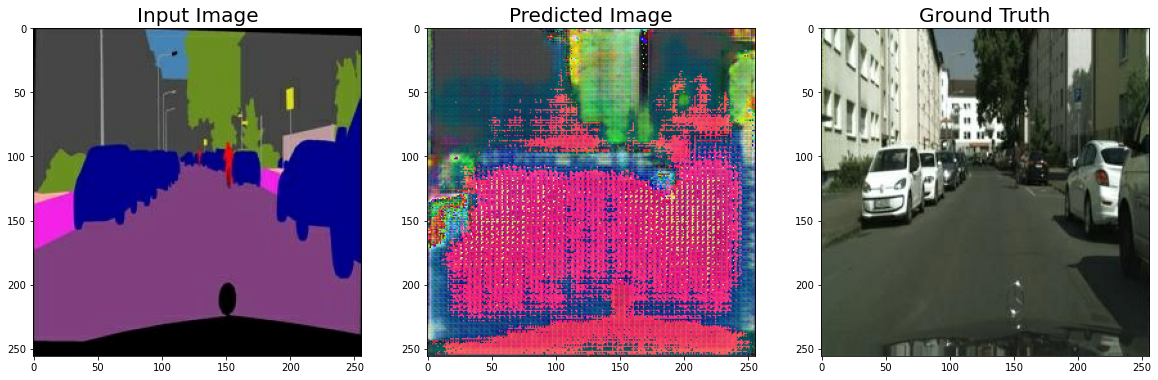

In [29]:
test_path = os.getenv('HOME')+'/aiffel/E17/conditional_generation/data/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=20)

# 회고

## 두번째 GAN

gan 모델 관련 노드가 처음이 아닌 것으로 알고있다. cifar10 이미지를 직접 생성해보는 노드였던가? 차이점이라면 전혀 주어지지 않은 상황에서 이미지를 그리는 방식에서 입력 이미지를 원하는 참 이미지와 맞는 형태로 변형하도록 학습하는 방식이라는 것이다. 그냥 직관적으로 생각해보면 훨씬 쉬울 것 같은데 막상 학습 결과만 놓고 봤을 때 크게 다르지 않다. exploration 10번 노드 진행 당시에도 250-300 epochs으로 진행했을 때 일부 식별가능한 이미지를 도출해냈었는데 이번 노드에서 200 epoch을 돌렸을 때도 형체를 알아볼 수 없고 겨우 색 정도를 비슷하게 맞춘 이미지를 생성해내는 것이 고작이였다. 아직 class와 함수 define의 코드들을 해석하는 것에 어려움이 많아서 하이퍼 파라미터를 적극적으로 변경해보지 못한 탓도 있는 것 같다. 10번 노드처럼 진행중 이미지와 결과를 모두 저장해가면서 회차 별로 비교하면서 쭉쭉 진행했으면 좋았을 것 같은데 뒤늦게 10번 노드 내용이 생각났을 때는 너무 여러 차례의 학습을 진행한 터라 지쳐버려서 하기 싫어졌다. 아직 열어보지도 못한 고잉디퍼를 어서 해야한다...

## 부족한 것

사실 새로 짜야하거나 수정할 코드가 많은 노드는 아니었는데, 학습 절차를 정의하는 과정에서 넣을 데이터를 수정하면서 너무 많이 헤맸다. 모델의 구조를 이해하지 못한 것인지, 짜여져 있는 코드의 구조를 이해를 못한 것인지(어쩌면 둘다) 계속 결과 이미지와 여타 시각화 부분이 엉뚱하게 나와서 한참을 헤매었다. epoch을 찔끔찔끔 올리다보니 변화가 눈에 띄지 않아서 내가 맞게 했다는 것도 인지하지 못하기도 했다. 생성 모델링은 가능하면 매우매우 높은 epoch으로 시작해보기로 하자. 그리고 가능하면 진행했던 노드의 내용들을 리마인드 해보면서 진행하는게 힌트가 많이 될 것 같기도 하다. 개인적으로 함수와 클래스 위주의 코드가 힘든 점을 발견했는데 이해하기 위해서 사용된 함수와 클래스를 모두 거꾸로 올라가 살펴보아야 한다는 점이다. 직접 짠 코드가 아니라서 그런 점이 크겠지만, 거의 리버스 엔지니어링을 하는 기분이었다. 매우 고통스럽다.